# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 23, 2625)
-----------------------
name: X_train
shape: (640, 23, 2473)
-----------------------
name: clip_sizes_test
shape: (2, 135)
-----------------------
name: clip_sizes_train
shape: (2, 133)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2625)
-----------------------
name: sel_win_nums_train
shape: (1, 2473)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2625)
-----------------------
name: y_train
shape: (1, 2473)
-----------------------
print sample EGG signal from one node:


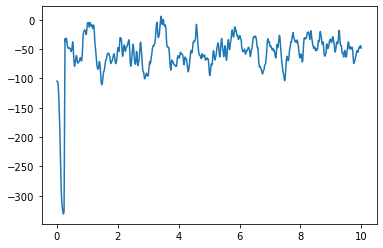

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_253.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [3]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

X_train: (640, 23, 2549)
X_test: (640, 23, 2549)
y_train: (1, 2549) Positive labes: 261.0
y_test: (1, 2549) Positive labes: 260.0


In [4]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

In [5]:
#save the shuffled indices
np.save("datasets/indices_253.npy",indices)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [6]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


##### 1.1.2 Visualize the mean covariance matrix across all training samples

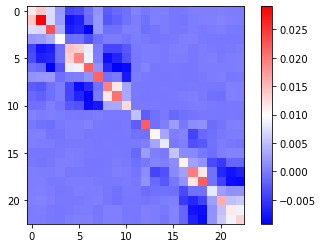

In [7]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

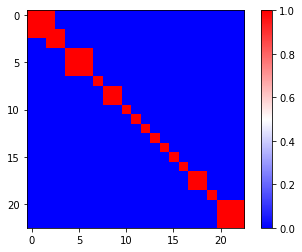

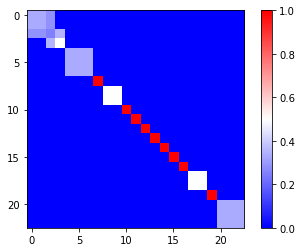

In [8]:
n = 3.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [9]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 257, 'M': 2548, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [10]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  5%|▌         | 1/20 [00:00<00:02,  8.64it/s]

device set to cpu


 20%|██        | 4/20 [00:00<00:01,  9.31it/s]

 35%|███▌      | 7/20 [00:00<00:01,  9.58it/s]

 45%|████▌     | 9/20 [00:00<00:01,  9.08it/s]

 50%|█████     | 10/20 [00:01<00:01,  9.23it/s]

Epoch: 1   Batch: 11 of size 128   Train loss: 135.0307159423828   Valid loss: 134.79870605468755

 65%|██████▌   | 13/20 [00:01<00:00,  9.42it/s]

 70%|███████   | 14/20 [00:01<00:00,  9.46it/s]

Epoch: 1   Batch: 15 of size 128   Train loss: 131.86453247070312   Valid loss: 131.71539306640625

 85%|████████▌ | 17/20 [00:01<00:00,  9.77it/s]

100%|██████████| 20/20 [00:02<00:00,  9.86it/s]

Epoch: 1   Batch: 20 of size 128   Train loss: 128.66539001464844   Valid loss: 129.30528259277344


In [11]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCN253_1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [12]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


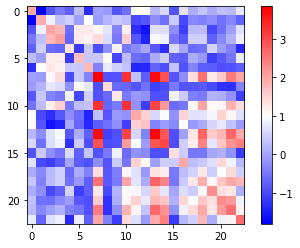

sample 1   label, 1.0


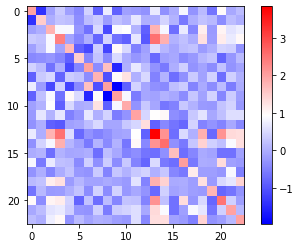

sample 2   label, 0.0


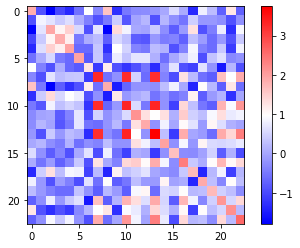

sample 3   label, 0.0


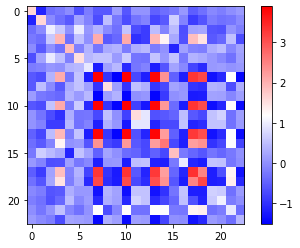

sample 4   label, 0.0


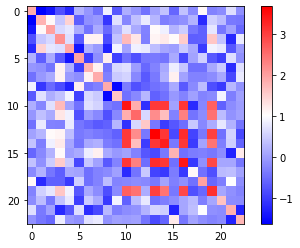

sample 5   label, 0.0


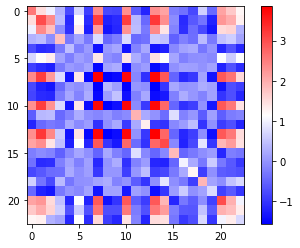

sample 6   label, 0.0


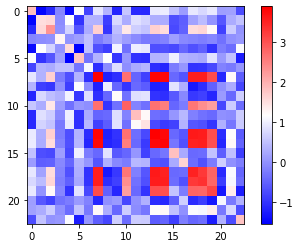

sample 7   label, 0.0


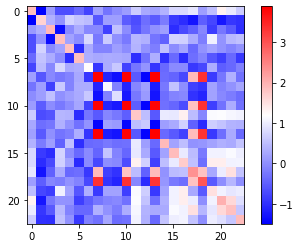

sample 8   label, 0.0


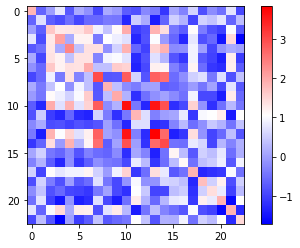

sample 9   label, 1.0


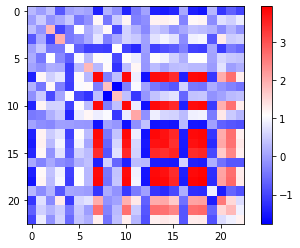

In [13]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [14]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [15]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/20 [00:00<?, ?it/s]

device set to cpu


  5%|▌         | 1/20 [00:00<00:10,  1.81it/s]

 10%|█         | 2/20 [00:01<00:10,  1.78it/s]

 15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

 20%|██        | 4/20 [00:02<00:09,  1.77it/s]

 25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

 30%|███       | 6/20 [00:03<00:07,  1.83it/s]

 35%|███▌      | 7/20 [00:03<00:07,  1.78it/s]

 40%|████      | 8/20 [00:04<00:06,  1.83it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.79it/s]

 50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.80it/s]

 60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

 65%|██████▌   | 13/20 [00:07<00:03,  1.80it/s]

 70%|███████   | 14/20 [00:07<00:03,  1.79it/s]

 75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

 80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

 85%|████████▌ | 17/20 [00:09<00:01,  1.81it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.77it/s]

 95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

100%|██████████| 20/20 [00:11<00:00,  1.80it/s]

Epoch: 1   Batch: 20 of size 128   Train loss: 125.71546936035156   Valid loss: 125.08547973632812


In [16]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDE253_1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [17]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


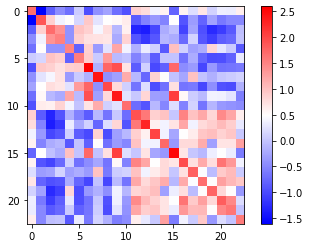

sample 1   label, 1.0


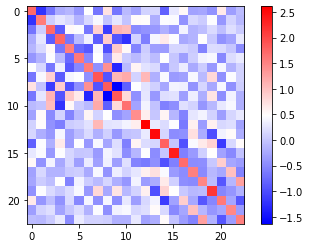

sample 2   label, 0.0


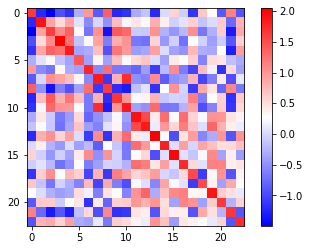

sample 3   label, 0.0


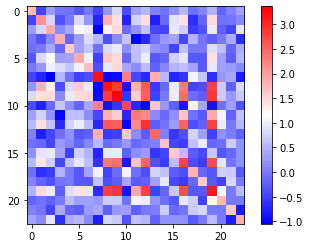

sample 4   label, 0.0


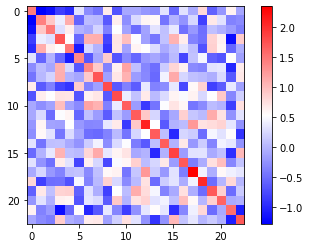

sample 5   label, 0.0


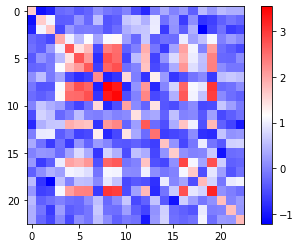

sample 6   label, 0.0


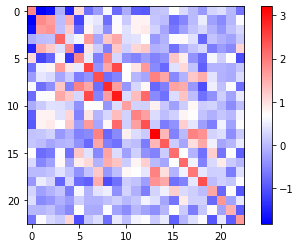

sample 7   label, 0.0


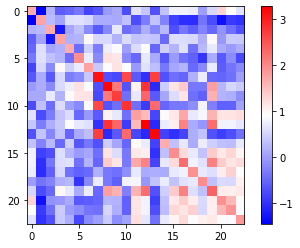

sample 8   label, 0.0


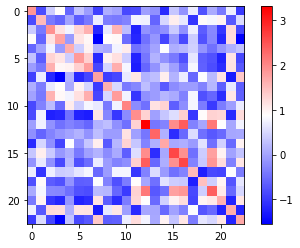

sample 9   label, 1.0


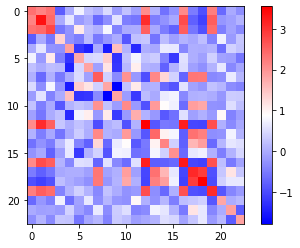

In [18]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [19]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [20]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [21]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


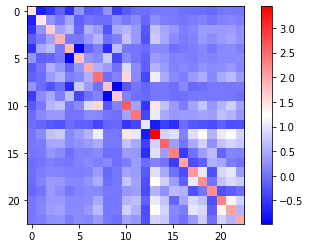

Average Non-Ictal


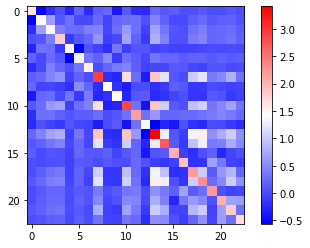

In [22]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


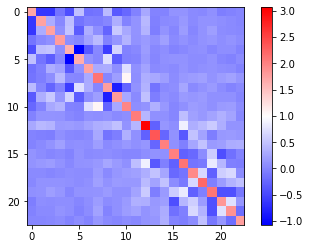

Average Non-Ictal


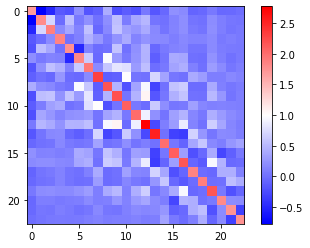

In [23]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [31]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1, 2], 
    'dropout':[-1, -1],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=276, out_features=138, bias=True)
    (1): ReLU()
    (2): Linear(in_features=138, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 138]          38,226
              ReLU-2                  [-1, 138]               0
            Linear-3                    [-1, 1]             139
           Sigmoid-4                    [-1, 1]               0
Total params: 38,365
Trainable params: 38,365
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
Epoch: 1   Train loss: 0.3737   Train accuracy: 0.005   Val loss: 0.309   Val accuracy: 0.29    weighted Val

In [32]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGCN, "models/MLPGCN253_2.pt")

model saved


###### Result

In [33]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.1371 F1 accuracy 0.596 Precision accuracy 0.442 Recall accuracy 0.915 AUC accuracy: 0.959
device set to cuda
threshold: 0.1  validation loss: 0.1371 F1 accuracy 0.653 Precision accuracy 0.517 Recall accuracy 0.888 AUC accuracy: 0.959
device set to cuda
threshold: 0.15  validation loss: 0.1371 F1 accuracy 0.702 Precision accuracy 0.591 Recall accuracy 0.865 AUC accuracy: 0.959
device set to cuda
threshold: 0.2  validation loss: 0.1371 F1 accuracy 0.72 Precision accuracy 0.633 Recall accuracy 0.835 AUC accuracy: 0.959
device set to cuda
threshold: 0.25  validation loss: 0.1371 F1 accuracy 0.732 Precision accuracy 0.665 Recall accuracy 0.815 AUC accuracy: 0.959
device set to cuda
threshold: 0.3  validation loss: 0.1371 F1 accuracy 0.739 Precision accuracy 0.699 Recall accuracy 0.785 AUC accuracy: 0.959
device set to cuda
threshold: 0.35  validation loss: 0.1371 F1 accuracy 0.751 Precision accuracy 0.727 Recall accuracy 0.777 AUC accur

##### 3.1.2 MLP for GDE

###### Training

In [27]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[0.5, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=276, out_features=276, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=276, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 276]               0
            Linear-2                  [-1, 276]          76,452
              ReLU-3                  [-1, 276]               0
           Dropout-4                  [-1, 276]               0
            Linear-5                    [-1, 1]             277
           Sigmoid-6                    [-1, 1]               0
Total params: 76,729
Trainable params: 76,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29

In [28]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGDE, "models/MLPGDE253_1.pt")

model saved


###### Result

In [29]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda', threshold = t)

device set to cuda
threshold: 0.05  validation loss: 0.1216 F1 accuracy 0.514 Precision accuracy 0.349 Recall accuracy 0.977 AUC accuracy: 0.971
device set to cuda
threshold: 0.1  validation loss: 0.1216 F1 accuracy 0.657 Precision accuracy 0.503 Recall accuracy 0.946 AUC accuracy: 0.971
device set to cuda
threshold: 0.15  validation loss: 0.1216 F1 accuracy 0.736 Precision accuracy 0.612 Recall accuracy 0.923 AUC accuracy: 0.971
device set to cuda
threshold: 0.2  validation loss: 0.1216 F1 accuracy 0.788 Precision accuracy 0.715 Recall accuracy 0.877 AUC accuracy: 0.971
device set to cuda
threshold: 0.25  validation loss: 0.1216 F1 accuracy 0.783 Precision accuracy 0.75 Recall accuracy 0.819 AUC accuracy: 0.971
device set to cuda
threshold: 0.3  validation loss: 0.1216 F1 accuracy 0.805 Precision accuracy 0.815 Recall accuracy 0.796 AUC accuracy: 0.971
device set to cuda
threshold: 0.35  validation loss: 0.1216 F1 accuracy 0.785 Precision accuracy 0.838 Recall accuracy 0.738 AUC accur